In [7]:
import numpy as np
import os
import g3utils as ut
import matplotlib.pyplot as plt
import so3g.proj
from spt3g import core
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from spt3g.core import G3Units as gu
import astropy.units as au

In [11]:
control_computer_g3_dir = "/media/player1/blast2020fc1/blasttng_g3"
roach1_pass3_file = os.path.join(control_computer_g3_dir, "testing/roach1_pass3.g3")

In [19]:
class AddRaDec:
    def __init__(self):
        ...

    def __call__(self, frame):
        if frame.type != core.G3FrameType.Scan:
            return

        # Approx location for this time frame
        middle_idx = len(frame["lon"]) // 2
        site = so3g.proj.EarthlySite(
            frame["lon"][middle_idx] / gu.deg,
            frame["lat"][middle_idx] / gu.deg,
            frame["alt"][middle_idx] / gu.m
        )

        # coords() returns an array with shape (n_time, 4); each 4-tuple contains values (lon, lat, cos(gamma), sin(gamma))
        # Construct a CelestialSightLine to az_el to on-sky coords
        times = np.array(frame["data"].times) / gu.s
        csl = so3g.proj.CelestialSightLine.naive_az_el(
            times,
            frame["az"] / gu.rad,
            frame["el"] / gu.rad,
            site=site
        )
        coords = csl.coords(so3g.proj.FocalPlane.boresight())

        
        x = np.mod(coords[0][:, 0], 2*np.pi) * gu.rad
        y = coords[0][:, 1] * gu.rad

        frame["ra"] = core.G3VectorDouble(x)
        frame["dec"] = core.G3VectorDouble(y)

In [29]:
# center of the sky map
ra0 = 231.15 * core.G3Units.deg
dec0 = -56.2 * core.G3Units.deg

# map dimensions
xlen = 1.4 * core.G3Units.deg
ylen = 0.9 * core.G3Units.deg

# pixel resolution
res = 1 * core.G3Units.arcmin


Calibration
PipelineInfo
Scan (x117)
EndProcessing


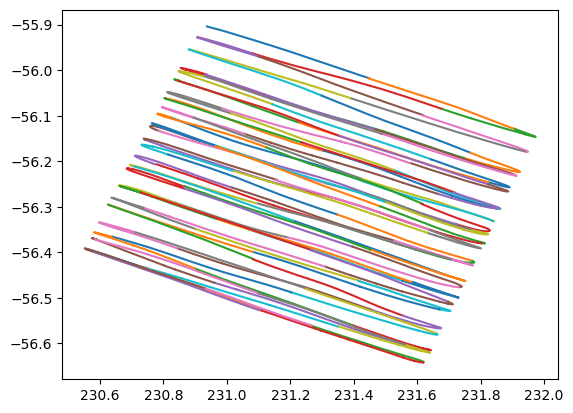

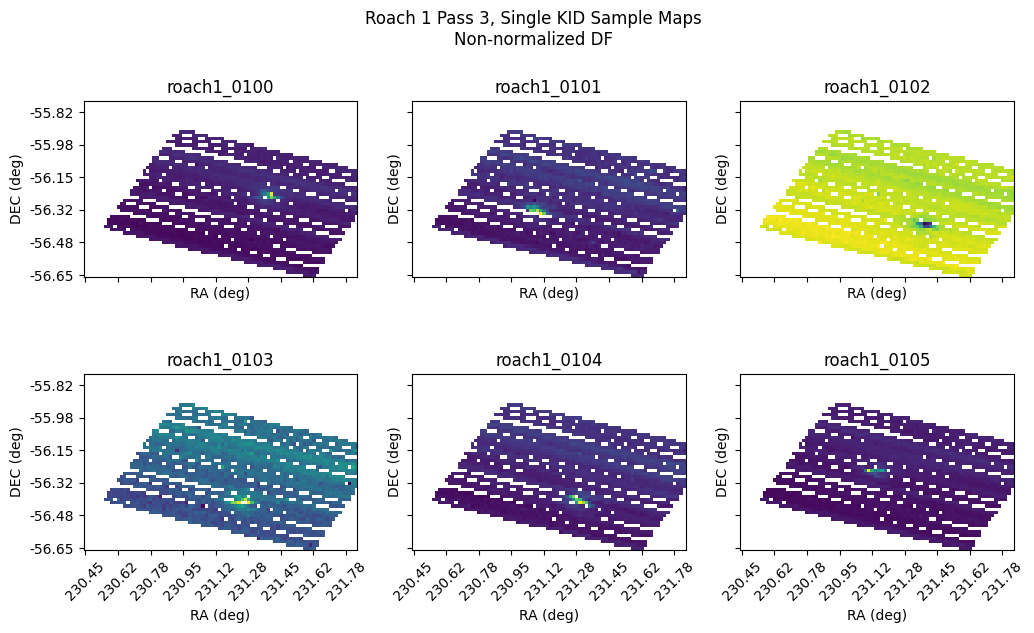

In [30]:
# instantiate binners
binners = [ut.SingleMapBinner(kid=f"roach1_0{i:03}", timestreams="df", ra0=ra0, dec0=dec0, xlen=xlen, ylen=ylen, res=res)
           for i in range(100, 106)]

pipe = core.G3Pipeline()
pipe.Add(core.G3Reader, filename=roach1_pass3_file)
pipe.Add(AddRaDec)
pipe.Add(ut.plot_ra_dec)
pipe.Add(ut.AddAllDF)
for binner in binners:
    pipe.Add(binner)
pipe.Add(ut.FrameCounter)
pipe.Run()

fig, axs = plt.subplots(2, 3, figsize=(12, 6.5), sharex='all', sharey='all')
fig.suptitle("Roach 1 Pass 3, Single KID Sample Maps"
            "\nNon-normalized DF")
for binner, ax in zip(binners, axs.flat):
    binner.plot(ax=ax)
plt.show()